In [283]:
import numpy as np
from ar1_approx import tauchenhussey
import scipy.interpolate as interpol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [284]:
##set model parameters
theta = .21
v = .64
delta = .1
beta = .96
phi = .5
rho = .9
sigma = .02
mu = 0
N = 10


## Problem 1:

A steady state competitive equilibrium implies a $v(\epsilon, k)$, policy $k'(\epsilon, k)$ and $n(\epsilon, k)$, mass of entrants per period, measure of active firms at the beginning and a real wage where the following are satisfied: 
- incumbent firms maximize value
- free entry 
- labor market clears
- measure of active firms is stationary

This implies the following equations:

Households:
$$ w^* \frac{1}{c^*} - a = 0 $$

Firms: (bellman equation)
$$ v(\epsilon,k) = \max_{k', n} e^\epsilon n^v - w^*n- (k' -(1-\delta)k \
- \frac{\phi}{2}{\left(\frac{k'}{k} - (1-\delta)\right)}^2k + \beta E(v(\epsilon',k')$$

Market Clearing:
$$N(g) = \int \int n(\epsilon, k, g)g(\epsilon, k) d\epsilon dk$$
$$C(g) = \int \int \left(y(\epsilon, k,g)-i(\epsilon,k,g)\right)g(\epsilon,k)d\epsilon dk$$

## Problem 2:

In [285]:
N_rep = .6
from scipy.optimize import fsolve
def steady_state_eqns(x, *args):
    N_rep, delta, beta, theta, v = args
    w = x[0]
    c = x[1]
    k = x[2]
    r = 1/beta - (1 - delta)
    ret = np.zeros(3)
    ret[0] = r - theta* N_rep**v * k**(theta-1)
    ret[1] = w - v* N_rep**(v-1) * k**(theta)
    ret[2] = c + k*delta - k**theta * N_rep**v
    return ret

In [286]:
params = N_rep, delta, beta, theta, v
ss_vals = fsolve(steady_state_eqns, [.1,.3,.1], args=params) 

In [287]:
print("Steady State Wage: {}".format(ss_vals[0]))
print("Steady State Consumption: {}".format(ss_vals[1]))
print("Steady State Capital: {}".format(ss_vals[2]))

Steady State Wage: 0.7829715643836618
Steady State Consumption: 0.6252258227354607
Steady State Capital: 1.088100188742222


## Problem 3

In [420]:

##interpolation function that returns function handle given interp type
def interpolate(k_grid, policy, method="pw-linear", ndegree=None, A=None ):
    if method == "pw-linear":
        t = interpol.interp1d(k_grid, policy, kind='linear',fill_value="extrapolate")
            
    elif method == "chebyshev":
        ###Get chebyshev coefficients 
        coeff = chebyshev.chebfit(k_grid, policy, ndegree)
        t = lambda x: chebyshev.chebval(x, coeff)

    elif method == "cubic-spline":
        t = interpol.interp1d(k_grid, policy, kind='cubic',fill_value="extrapolate")
        
    else: raise NameError("invalid choice of interpolation method. Valid methods are \
                           'pw-linear,' 'chebyshev,' 'cubic-spline,' or 'ar_1'")
    return t


def bellman_operator(kprime, kprime_ind, *args):
    
    value_mat, k_grid, pi_mat_ind, pi_mat, phi, k, delta, \
    theta, v, shock, cf, w, beta = args
    n = (w/(v*np.exp(shock)*k**theta))**(1/(v-1))

    expectation = np.dot(pi_mat[pi_mat_ind,:], value_mat[:, kprime_ind])
        
#     print("Bellman Operator:")
#     print(np.exp(shock)*(k**theta)*(n**v))
#     print(w*n)
#     print(kprime - (1-delta)*k)
#     print(phi/2*(kprime/k - (1-delta))**2 * k)
#     print(expectation*beta)
    production = np.exp(shock)*k**theta*n**v
    wage = w*n
    investment = kprime - (1 - delta)*k
    cost_aq = k * phi/2 * (kprime/k  - (1-delta))**2
    v1 = production - wage - investment - cost_aq + beta*expectation
#     v1 = production - production - wagewage + beta*expectation
#     print("v1:  {}".format(v1))
#     print("other thing: {}".format((1-delta)*k))
#     print("v1 - cf {}".format(v1- cf))
#    print("\nKprime{}, Interpolation{}".format(kprime, interp(kprime)))
    
    ret = np.max([(1-delta)*k, v1 - cf])
#     print(ret)
#     print("\n\n")
    return ret
            


In [438]:
##perform value function iteration
w = ss_vals[0]
cf = .01
init_val = np.log(np.tile(np.linspace(1, 10, 25), (10,1)) + 5 )
k_grid = np.linspace(0.01, 4, 25)
shocks, pi_mat = tauchenhussey(N, mu, rho, sigma, sigma)
shocks = np.squeeze(shocks)
updated_val = init_val
val_iter = 0
maxiter = 2000
mindist = 1e-8
init_policy = np.ones(init_val.shape)
dist = 100
while (val_iter < maxiter) and (dist > mindist):
    val_iter += 1
    init_val = updated_val
    updated_val = np.zeros(init_val.shape)
    updated_policy = np.zeros(init_val.shape)
    
    for i in range(len(k_grid)):
        
        for j in range(len(shocks)):

            k_index = i
            k = k_grid[i]
            shock = shocks[j]
            shock_index = j
            best_val = -100
            best_kprime = 0
                            
            params = (init_val, k_grid, shock_index, pi_mat, phi, k, delta, \
                theta, v, shock, cf, w, beta)
            vals = np.zeros(len(k_grid))
            count = 0
            for t in range(len(k_grid)):
                kprime = k_grid[t]
                
                val = bellman_operator(kprime, t,  *params)
                vals[count] = val
                if val > best_val:
                    best_val = val
                    best_kprime = kprime
                count +=1
            #print("Vals:  {}".format(vals))
            updated_val[shock_index, k_index] = best_val
            updated_policy[shock_index, k_index] = best_kprime
    
    dist = ((updated_val - init_val) ** 2).sum()

    print('Iteration=', val_iter, ', Dist=', dist)
    

    
    

Iteration= 1 , Dist= 458.2871154566311
Iteration= 2 , Dist= 8.025277278203397
Iteration= 3 , Dist= 2.8649712984517253
Iteration= 4 , Dist= 1.4411084270297738
Iteration= 5 , Dist= 0.8876847927983489
Iteration= 6 , Dist= 0.6268004235371449
Iteration= 7 , Dist= 0.48303183698110513
Iteration= 8 , Dist= 0.39369841183976606
Iteration= 9 , Dist= 0.33455203704498404
Iteration= 10 , Dist= 0.2900832891446402
Iteration= 11 , Dist= 0.2524548658692319
Iteration= 12 , Dist= 0.21830243684658837
Iteration= 13 , Dist= 0.19710252294731456
Iteration= 14 , Dist= 0.1785794654061551
Iteration= 15 , Dist= 0.16233971719607945
Iteration= 16 , Dist= 0.1476821621517985
Iteration= 17 , Dist= 0.1343989815362536
Iteration= 18 , Dist= 0.12235794851284224
Iteration= 19 , Dist= 0.111374040541881
Iteration= 20 , Dist= 0.09893970237137363
Iteration= 21 , Dist= 0.08903537281562905
Iteration= 22 , Dist= 0.08091203601926883
Iteration= 23 , Dist= 0.07373556762998215
Iteration= 24 , Dist= 0.06721933083159957
Iteration= 25 , 

Iteration= 189 , Dist= 6.734200179439727e-08
Iteration= 190 , Dist= 6.206067890319942e-08
Iteration= 191 , Dist= 5.7193612585432285e-08
Iteration= 192 , Dist= 5.2708301822677936e-08
Iteration= 193 , Dist= 4.8574796352844694e-08
Iteration= 194 , Dist= 4.4765496394322646e-08
Iteration= 195 , Dist= 4.125496808485012e-08
Iteration= 196 , Dist= 3.8019773443142475e-08
Iteration= 197 , Dist= 3.503831367104054e-08
Iteration= 198 , Dist= 3.229068477628943e-08
Iteration= 199 , Dist= 2.9758544533355066e-08
Iteration= 200 , Dist= 2.742498988980002e-08
Iteration= 201 , Dist= 2.5274444007612766e-08
Iteration= 202 , Dist= 2.3292552167890683e-08
Iteration= 203 , Dist= 2.1466085855117876e-08
Iteration= 204 , Dist= 1.978285437119945e-08
Iteration= 205 , Dist= 1.82316233900409e-08
Iteration= 206 , Dist= 1.6802039908157376e-08
Iteration= 207 , Dist= 1.5484563082745185e-08
Iteration= 208 , Dist= 1.4270400500685549e-08
Iteration= 209 , Dist= 1.3151449458256071e-08
Iteration= 210 , Dist= 1.212024283824144e-0

[[0.17625 0.3425  0.50875 0.50875 0.675   0.84125 0.84125 1.0075  1.17375
  1.17375 1.34    1.34    1.50625 1.50625 1.6725  1.6725  1.83875 2.005
  2.005   2.17125 2.17125 2.3375  2.3375  2.50375 2.50375]
 [0.17625 0.3425  0.50875 0.675   0.675   0.84125 0.84125 1.0075  1.17375
  1.17375 1.34    1.50625 1.50625 1.6725  1.6725  1.83875 1.83875 2.005
  2.17125 2.17125 2.17125 2.3375  2.3375  2.50375 2.50375]
 [0.17625 0.3425  0.50875 0.675   0.675   0.84125 0.84125 1.0075  1.17375
  1.34    1.34    1.50625 1.50625 1.6725  1.6725  1.83875 2.005   2.005
  2.17125 2.17125 2.3375  2.3375  2.50375 2.50375 2.67   ]
 [0.17625 0.3425  0.50875 0.675   0.675   0.84125 0.84125 1.0075  1.17375
  1.34    1.34    1.50625 1.6725  1.6725  1.6725  1.83875 2.005   2.005
  2.17125 2.17125 2.3375  2.3375  2.50375 2.50375 2.67   ]
 [0.17625 0.3425  0.50875 0.675   0.675   0.84125 0.84125 1.0075  1.17375
  1.34    1.34    1.50625 1.6725  1.6725  1.6725  1.83875 2.005   2.005
  2.17125 2.17125 2.3375  2.3375  

<Figure size 432x288 with 0 Axes>

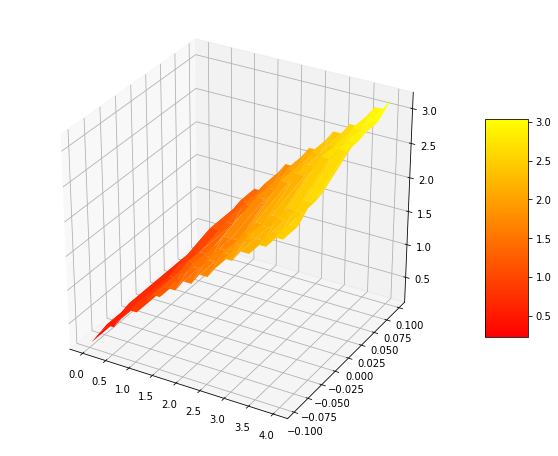

In [439]:
print(updated_policy)
fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(k_grid,shocks)
surface =ax.plot_surface(x,y, updated_policy, cmap=cm.autumn)
fig.colorbar(surface,shrink=.5, aspect=5)

<Figure size 432x288 with 0 Axes>

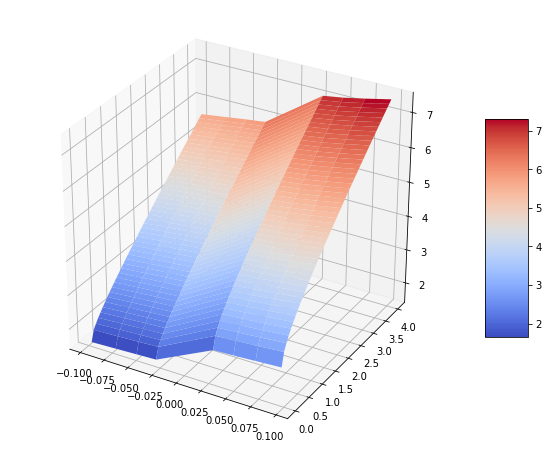

In [428]:
fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(k_grid,shocks)
surface =ax.plot_surface(y,x, updated_val, cmap=cm.coolwarm)
fig.colorbar(surface,shrink=.5, aspect=5)

[[1.52331731 1.83433417 1.96855163 2.08351306 2.18873343 2.28801341
  2.38366067 2.47754294 2.56916467 2.65755451 2.74427818 2.82947723
  2.91318962 2.99625955 3.07830931 3.15909356 3.23990808 3.3197787
  3.39886762 3.47754562 3.55546421 3.63340362 3.71073948 3.78760152
  3.86412132]
 [1.55459932 1.87175242 2.01057381 2.12942952 2.23799236 2.34006795
  2.43783383 2.53268853 2.62624199 2.71732577 2.80480037 2.89172101
  2.97723063 3.06126882 3.14502025 3.2275773  3.30900533 3.39051275
  3.47098124 3.55081582 3.63014972 3.70882496 3.78748372 3.86551729
  3.94309286]
 [1.58187183 1.90426094 2.04696108 2.16909899 2.28050754 2.38503256
  2.48484576 2.58141687 2.67572971 2.76888819 2.8578214  2.94569845
  3.03261165 3.11833766 3.20268509 3.28693554 3.36969406 3.45177779
  3.5338182  3.61442884 3.69491949 3.77480658 3.85411808 3.93341665
  4.01160744]
 [1.60774443 1.93423452 2.07975634 2.20424416 2.31769767 2.42403479
  2.52544754 2.62340086 2.71895549 2.81297557 2.90329076 2.9918184
  3.0798

<Figure size 432x288 with 0 Axes>

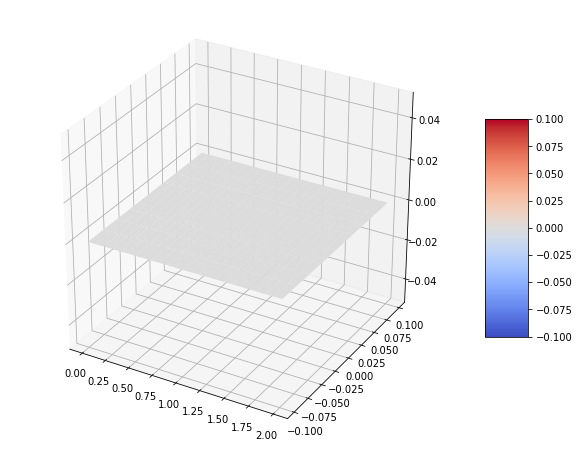

In [363]:
indicator = np.zeros(updated_val.shape)
for i in range(len(shocks)):
    for j in range(len(k_grid)):
        if updated_val[i,j] == (1-delta)*k_grid[j]:
            indicator[i,j] = 1
print(updated_val)
fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surface =ax.plot_surface(x,y, indicator, cmap=cm.coolwarm)
fig.colorbar(surface,shrink=.5, aspect=5)

## Problem 4:

In [443]:
def wage_func(w, *params):
    #perform value function iteration
    pi_mat, phi, delta, theta, v, beta = params
    ce = 1
    cf = .01
    init_val = np.log(np.tile(np.linspace(1, 10, 25), (10,1)) + 5 )
    k_grid = np.linspace(0.01, 2, 25)
    shocks, pi_mat = tauchenhussey(N, mu, rho, sigma, sigma)
    shocks = np.squeeze(shocks)
    updated_val = init_val
    val_iter = 0
    maxiter = 2000
    mindist = 1e-8
    init_policy = np.ones(init_val.shape)
    dist = 100
    while (val_iter < maxiter) and (dist > mindist):
        val_iter += 1
        init_val = updated_val
        updated_val = np.zeros(init_val.shape)
        updated_policy = np.zeros(init_val.shape)

        for i in range(len(k_grid)):

            for j in range(len(shocks)):

                k_index = i
                k = k_grid[i]
                shock = shocks[j]
                shock_index = j
                best_val = -100
                best_kprime = 0

                params = (init_val, k_grid, shock_index, pi_mat, phi, k, delta, \
                    theta, v, shock, cf, w, beta)
                vals = np.zeros(len(k_grid))
                count = 0
                for t in range(len(k_grid)):
                    kprime = k_grid[t]

                    val = bellman_operator(kprime, t,  *params)
                    vals[count] = val
                    if val > best_val:
                        best_val = val
                        best_kprime = kprime
                    count +=1
                #print("Vals:  {}".format(vals))
                updated_val[shock_index, k_index] = best_val
                updated_policy[shock_index, k_index] = best_kprime

        dist = ((updated_val - init_val) ** 2).sum()

        
        ##compute vhat
        vhat = np.zeros(len(shocks))
        integral = 0
        for j in range(len(shocks)):
            shock = shocks[j]
            vals = np.zeros(len(k_grid))
            for i in range(len(k_grid)):
                kprime_ind = i
                kprime = k_grid[i]
                expectation = np.dot(pi_mat[j,:], updated_val[:, kprime_ind])
                vals[i] = -kprime + beta*expectation
            vhat[j] = np.max(vals)
        print(vhat)  
        for j in range(1, len(shocks)-1):
            integral += vhat[j]*v*(shocks[j] - shocks[j-1])
        
        return ce - integral

In [444]:
params = (pi_mat, phi, delta, theta, v, beta)
wage = fsolve(wage_func, .5, args = params)

[1.76318784 1.78266775 1.80139903 1.81236011 1.81236011 1.9105457
 1.9105457  1.92868422 1.96577573 2.01487675]
[1.76318784 1.78266775 1.80139903 1.81236011 1.81236011 1.9105457
 1.9105457  1.92868422 1.96577573 2.01487675]
[1.76318784 1.78266775 1.80139903 1.81236011 1.81236011 1.9105457
 1.9105457  1.92868422 1.96577573 2.01487675]
[1.76318784 1.78266774 1.80139902 1.8123601  1.8123601  1.91054569
 1.91054569 1.92868421 1.96577571 2.01487673]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


[-96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01]
[1.65392694 1.65693288 1.65958457 1.66105455 1.66105455 1.67707595
 1.67707595 1.68048716 1.68709607 1.69512488]
[1.76318784 1.78266774 1.80139902 1.8123601  1.8123601  1.91054569
 1.91054569 1.92868421 1.96577571 2.01487673]
[-96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01 -96.01]
[1.65392694 1.65693288 1.65958457 1.66105455 1.66105455 1.67707595
 1.67707595 1.68048716 1.68709607 1.69512488]
[2.13223511 2.20277314 2.26499823 2.29949286 2.29949286 2.57083988
 2.57083988 2.61488442 2.70021683 2.80388247]
[16.5306004  17.49390259 18.34367925 18.81475502 18.81475502 22.52040425
 22.52040425 23.12189837 24.28724001 25.70294924]
[3.04000148 3.16682515 3.27870261 3.34072214 3.34072214 3.82858986
 3.82858986 3.90777964 4.06120284 4.24758822]
[ 8.99382529  9.48981313  9.92734861 10.16989748 10.16989748 12.07787295
 12.07787295 12.387572   12.9875865  13.71651099]
[5.93490358 6.24122435 6.5114451  6.66124264 

In [445]:
wage

array([0.13671524])